In [1]:
from oemof import solph
import tsam.timeseriesaggregation as tsam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def preprocessing(noTypicalPeriods, hoursPerPeriod, data):
    aggregation = tsam.TimeSeriesAggregation(
        data,
        noTypicalPeriods=noTypicalPeriods,
        hoursPerPeriod=hoursPerPeriod,
        clusterMethod='k_means'
    )

    agg_data = aggregation.createTypicalPeriods()

    agg_data.index.names = ['TypicalPeriod', 'TimeStep']
    agg_data.reset_index(inplace=True)

    return aggregation, agg_data

In [3]:
def optimization(agg_data):
    timeindex = pd.date_range('2024-01-01 00:00', freq='h', periods=agg_data.shape[0])
    es = solph.EnergySystem(
        timeindex=timeindex, infer_last_interval=True
    )

    b_gas = solph.Bus("gas bus")
    b_electricity = solph.Bus("electricity bus")
    b_heat = solph.Bus("heat bus")

    source_gas = solph.components.Source(
        "gas source",
        outputs={b_gas: solph.Flow(variable_costs=agg_data["gas_price"] + agg_data["co2_price"])}
    )
    source_electricity = solph.components.Source(
        "electricity source",
        outputs={b_electricity: solph.Flow(variable_costs=agg_data["el_spot_price"])}
    )
    sink_heat = solph.components.Sink(
        "heat demand",
        inputs={b_heat: solph.Flow(fix=agg_data["heat"], nominal_value=1)}
    )

    heat_pump = solph.components.Converter(
        label="heat pump",
        inputs={b_electricity: solph.Flow()},
        outputs={b_heat: solph.Flow(nominal_value=100)},
        conversion_factors={b_heat: 3.5}
    )
    boiler = solph.components.Converter(
        label="gas boiler",
        inputs={b_gas: solph.Flow()},
        outputs={b_heat: solph.Flow(nominal_value=100)},
        conversion_factors={b_heat: 0.9}
    )

    heat_slack = solph.components.Source(
        label="heat slack",
        outputs={b_heat: solph.Flow(variable_costs=1000)}
    )

    storage = solph.components.GenericStorage(
        label="heat storage",
        inputs={b_heat: solph.Flow(nominal_value=50)},
        outputs={b_heat: solph.Flow(nominal_value=50)},
        nominal_storage_capacity=24 * 50,
        initial_storage_level=0.5,
        balanced=True
    )

    es.add(
        b_gas, b_electricity, b_heat,
        source_electricity, source_gas, sink_heat, heat_slack,
        heat_pump, boiler, storage
    )

    model = solph.Model(es)

    _ = model.solve("gurobi")

    results = solph.views.convert_keys_to_strings(model.results())

    return results

In [4]:
def postprocessing(results, agg_data, aggregation):
    unitdata = pd.DataFrame()
    for vertex, data in results.items():
        if vertex[-1] != 'None':
            unitdata[' to '.join(vertex)] = data['sequences']['flow']
        else:
            unitdata[f'{vertex[0]} storage content'] = data['sequences']['storage_content']

    unitdata.dropna(inplace=True)
    unitdata.reset_index(inplace=True, drop=True)

    unitdata = pd.concat([unitdata, agg_data[['TypicalPeriod', 'TimeStep']]], axis=1)
    unitdata.set_index(['TypicalPeriod', 'TimeStep'], inplace=True)

    matched_indices = aggregation.indexMatching()

    desagg_data = pd.DataFrame(index=matched_indices.index, columns=unitdata.columns)
    for idx in matched_indices.index:
        desagg_data.loc[idx, :] = unitdata.loc[
            (matched_indices.loc[idx, 'PeriodNum'],matched_indices.loc[idx, 'TimeStep']), :
            ]

    return desagg_data

In [5]:
ts_in = pd.read_csv("time_series.csv", index_col=0, parse_dates=True)
ts_in = ts_in.drop(columns="ef_om")
ts_in = ts_in.iloc[:-24, :]
ts_in.shape

(8736, 4)

In [6]:
aggregation, agg_data = preprocessing(noTypicalPeriods=10, hoursPerPeriod=168, data=ts_in)

In [7]:
agg_data

,TypicalPeriod,TimeStep,co2_price,el_spot_price,gas_price,heat
0,0,0,25.518571,29.021429,15.991429,116.730000
1,0,1,25.518571,28.098571,15.991429,124.241429
2,0,2,25.518571,27.411429,15.991429,132.255714
3,0,3,25.518571,27.922857,15.991429,148.618571
4,0,4,25.518571,32.697143,15.991429,157.992857
...,...,...,...,...,...,...
1675,9,163,25.526000,49.932000,13.373800,54.199881
1676,9,164,25.526000,44.468000,13.373800,56.629515
1677,9,165,25.526000,40.606000,13.373800,56.961312
1678,9,166,25.526000,35.306000,13.373800,57.489545


In [8]:
results = optimization(agg_data=agg_data)
results

{('electricity bus',
  'heat pump'): {'scalars': Series([], Name: 2024-01-01 00:00:00, dtype: float64), 'sequences': variable_name             flow
  2024-01-01 00:00:00  28.571429
  2024-01-01 01:00:00  28.571429
  2024-01-01 02:00:00  28.571429
  2024-01-01 03:00:00  28.571429
  2024-01-01 04:00:00  28.571429
  ...                        ...
  2024-03-10 20:00:00   1.894147
  2024-03-10 21:00:00   1.988946
  2024-03-10 22:00:00   2.139870
  2024-03-10 23:00:00  28.571429
  2024-03-11 00:00:00        NaN
  
  [1681 rows x 1 columns]},
 ('electricity source',
  'electricity bus'): {'scalars': Series([], Name: 2024-01-01 00:00:00, dtype: float64), 'sequences': variable_name             flow
  2024-01-01 00:00:00  28.571429
  2024-01-01 01:00:00  28.571429
  2024-01-01 02:00:00  28.571429
  2024-01-01 03:00:00  28.571429
  2024-01-01 04:00:00  28.571429
  ...                        ...
  2024-03-10 20:00:00   1.894147
  2024-03-10 21:00:00   1.988946
  2024-03-10 22:00:00   2.139870
  20

In [9]:
desagg_data = postprocessing(results=results, agg_data=agg_data, aggregation=aggregation)
desagg_data

,electricity bus to heat pump,electricity source to electricity bus,gas boiler to heat bus,gas bus to gas boiler,gas source to gas bus,heat bus to heat demand,heat bus to heat storage,heat pump to heat bus,heat slack to heat bus,heat storage storage content,heat storage to heat bus
Date,,,,,,,,,,,
2019-01-01 00:00:00,28.571429,28.571429,79.8925,88.769444,88.769444,179.8925,0.0,100.0,0.0,1200.0,0.0
2019-01-01 01:00:00,28.571429,28.571429,82.3425,91.491667,91.491667,182.3425,0.0,100.0,0.0,1200.0,0.0
2019-01-01 02:00:00,28.571429,28.571429,89.3175,99.241667,99.241667,189.91,0.0,100.0,0.0,1200.0,0.5925
2019-01-01 03:00:00,28.571429,28.571429,100.0,111.111111,111.111111,199.4075,50.0,100.0,0.0,1199.4075,49.4075
2019-01-01 04:00:00,28.571429,28.571429,100.0,111.111111,111.111111,212.045,0.0,100.0,12.045,1200.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 19:00:00,28.571429,28.571429,100.0,111.111111,111.111111,199.265,50.0,100.0,0.0,1142.609,49.265
2019-12-30 20:00:00,28.571429,28.571429,100.0,111.111111,111.111111,186.898,50.0,100.0,0.0,1143.344,36.898
2019-12-30 21:00:00,28.571429,28.571429,100.0,111.111111,111.111111,174.573,50.0,100.0,0.0,1156.446,24.573


Text(0, 0.5, 'Stündliche Wärmeproduktion in MW')

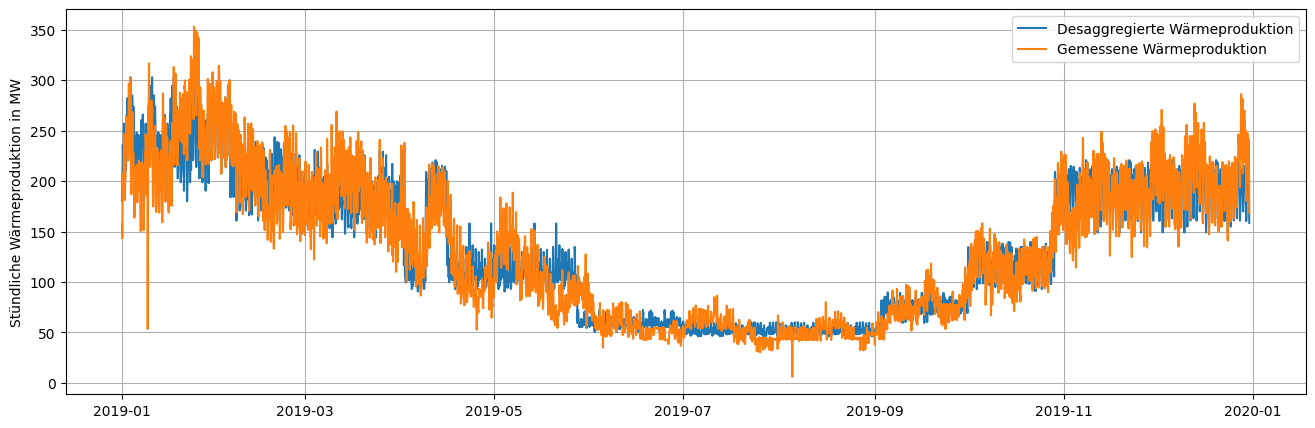

In [10]:
fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(desagg_data['heat bus to heat demand'], label='Desaggregierte Wärmeproduktion')
ax.plot(ts_in['heat'], label='Gemessene Wärmeproduktion')

ax.legend()
ax.grid()
ax.set_ylabel('Stündliche Wärmeproduktion in MW')

Text(0, 0.5, 'Wärmespeicherfüllstand in MWh')

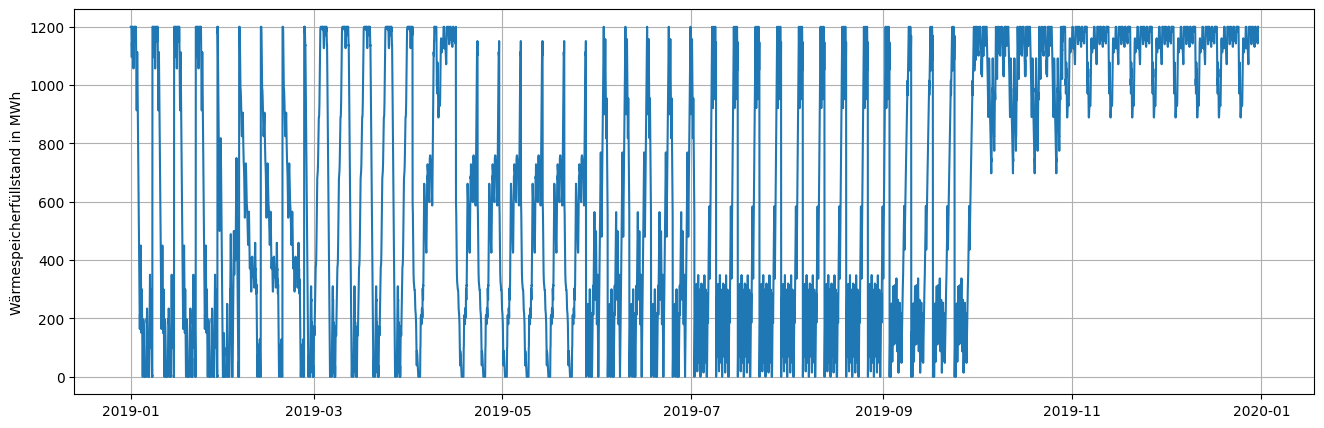

In [11]:
fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(desagg_data['heat storage storage content'])

ax.grid()
ax.set_ylabel('Wärmespeicherfüllstand in MWh')

In [12]:
ts_in = pd.read_csv("time_series.csv", index_col=0, parse_dates=True)
ts_in = ts_in.drop(columns="ef_om")
ts_in = ts_in.iloc[:-24, :]

print('Perfomance Clustering & Preprocessing:')
%timeit aggregation, agg_data = preprocessing(noTypicalPeriods=10, hoursPerPeriod=168, data=ts_in)
print('Perfomance Optimization:')
%timeit results = optimization(agg_data=agg_data)
print('Perfomance Desaggregation:')
%timeit desagg_data = postprocessing(results=results, agg_data=agg_data, aggregation=aggregation)

Perfomance Clustering & Preprocessing:
1.01 s ± 8.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Perfomance Optimization:
1.42 s ± 151 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Perfomance Desaggregation:
1.51 s ± 43.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
